**Author: Nico Grisouard, nicolas.grisouard@physics.utoronto.ca**

*Supporting textbook chapters for week 8: Chapter 9*

Lecture 8 (and 9), topics:
* Classifying PDEs
* Elliptic equation solvers: Jacobi, Gauss-Seidel, overrelaxation
* Parabolic equation solver: FTCS (Forward Time, Centered Space)
* Stability,
* Implicit and Crank-Nicholson methods,
* Spectral method.

# Intro

## Classifying PDEs

Recall conical equations in geometry:
$$ ax^2 + b xy + cy^2 + dx + ey = f, $$
classified using 
$$ \Delta = b^2 - 4ac.$$

1. $\Delta = 0$: equation for a parabola,
3. $\Delta < 0$: equation for an ellipse,
2. $\Delta > 0$: equation for a hyperbola.

![By Pbroks13 [CC BY 3.0  (https://creativecommons.org/licenses/by/3.0)], from Wikimedia Commons](500px-Conic_sections_with_plane.png)

What does it have to do with PDEs?
$$ a\frac{\partial^2 \phi}{\partial x^2} + b\frac{\partial^2 \phi}{\partial x\partial y} + c\frac{\partial^2 \phi}{\partial y^2} + d\frac{\partial\phi}{\partial x} +  e\frac{\partial\phi}{\partial y} = f.$$

Same classification applies (imagine Fourier transforms to convince yourself):
$$ \Delta = b^2 - 4ac.$$

1. $\Delta = 0$: parabolic PDE,
3. $\Delta < 0$: elliptic PDE,
2. $\Delta > 0$: hyperbolic PDE.

$$ a\frac{\partial^2 \phi}{\partial x^2} + b\frac{\partial^2 \phi}{\partial x\partial y} + c\frac{\partial^2 \phi}{\partial y^2} + d\frac{\partial\phi}{\partial x} +  e\frac{\partial\phi}{\partial y} = f.$$

Same classification applies (imagine Fourier transforms to convince yourself):
$$ \Delta = b^2 - 4ac.$$

1. Canonical parabolic PDE: the diffusion equation, $\ \displaystyle \kappa \nabla^2 \phi  - \frac{\partial T}{\partial t} = 0$,
3. Canonical elliptic PDE: the Poisson equation, $\ \nabla^2 \phi = \rho$,
2. Canonical hyperbolic PDE: the wave equation, $\ \displaystyle c^2 \nabla^2 \phi  - \frac{\partial^2 T}{\partial t^2} = 0.$

Note: we use these expressions even if $\nabla^2 = \partial_x^2 + \partial_y^2 + \partial_z^2$, i.e., for 4D PDEs. 
It is a "perversion" of the original classification (see http://www.math.toronto.edu/courses/apm346h1/20129/LA.html), but usually harmless in Physics.

* Solving partial differential equations is one of the pinnacles of computational physics, bringing together many methods.
* Parabolic, hyperbolic, elliptic PDE: each type comes with design decisions on how to discretize and implement numerical methods,
* Stability is crucial

## Calculating the second derivative

* Recall central difference calculation of 2nd derivative (§5.10.5):
$$f''(x) = \frac{f(x+h) - 2f(x)+ f(x-h)}{h^2} - \frac{1}{12}h^2 f^{(4)}(x) + \dots{}$$

## General approach

* Discretize system spatially and temporally. Can use
    * Finite difference
    * Spectral coefficients
    * Etc.
* $\Rightarrow$ set of coupled ODEs that you need to solve in an efficient way.
* Spatial derivatives bring information in from neighbouring points $\Rightarrow$ coupling,
* $\Rightarrow$ errors depend on space and time and can get wave-like characteristics.

# Elliptic equations

* For solutions of Laplace's or Poisson's equation.
* E.g.: electrostatics, with electric potential $\phi$ s.t. $\vec E  = \nabla \phi$, in the absence of charges ($\rho \equiv 0$).
* Gauss' law:
$$\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = 0$$

![Newman fig. 9.2](fig9-2.png)

On regular square grid, finite difference form of 2D Laplacian is
$$\nabla^2 \phi  = \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2},$$
$$\frac{\partial^2 \phi}{\partial x^2} \approx \frac{\phi(x+a, y) - 2\phi(x, y)+ \phi(x-a, y)}{a^2},$$
$$\frac{\partial^2 \phi}{\partial y^2} \approx \frac{\phi(x, y+a) - 2\phi(x)+ \phi(x, y-a)}{a^2},$$
$$\text{Gauss' law}\ \Rightarrow\ 0 \approx \phi(x+a, y) + \phi(x-a, y) + \phi(x, y+a) + \phi(x, y-a) - 4\phi(x).$$

* Put together a series of equations of the form
    $$\phi(x+a, y) + \phi(x-a, y) + \phi(x, y+a) + \phi(x, y-a) - 4\phi(x) = 0$$
    for each $x$ and $y$, subject to boundary conditions.
* $\phi$ or derivative $\partial\phi/\partial \xi$ ($\xi = x,\ y,$ or both) given on boundary. How would you handle these?
* If $\phi$ given, use this value for adjacent points.
* If $\partial\phi/\partial \xi$ given, find algebraic relationship between points near to boundary using finite difference.
* Could solve using matrix methods:
    $$\mathbf L \phi = \mathbf R \phi,$$
    but a simpler method is possible.


## Jacobi relaxation method

$$\phi(x+a, y) + \phi(x-a, y) + \phi(x, y+a) + \phi(x, y-a) - 4\phi(x) = 0$$
* Iterate the rule
$$\underbrace{\phi'}_{\substack{\text{``}\phi\\prime\text{''}}}(x, y) = \frac{\phi(x+a, y) + \phi(x-a, y) + \phi(x, y+a) + \phi(x, y-a)}4.$$
* Much like the relaxation method for finding solutions of $f(x) = x$,
* For this problem it turns out that Jacobi Relaxation is always stable and so always gives a solution!
* Let's look at `laplace.py`

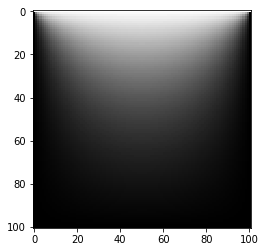

In [3]:
# %load laplace.py
# Newman's laplace.py
from numpy import empty, zeros, max
from pylab import imshow, gray, show

# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-6   # Target accuracy

# Create arrays to hold potential values
phi = zeros([M+1, M+1], float)
phi[0, :] = V
phiprime = empty([M+1, M+1], float)

# Main loop
delta = 1.0
while delta > target:

    # Calculate new values of the potential
    for i in range(M+1):
        for j in range(M+1):
            if i == 0 or i == M or j == 0 or j == M:
                phiprime[i, j] = phi[i, j]
            else:
                phiprime[i, j] = (phi[i+1, j] + phi[i-1, j]
                                  + phi[i, j+1] + phi[i, j-1])/4

    # Calculate maximum difference from old values
    delta = max(abs(phi-phiprime))

    # Swap the two arrays around
    phi, phiprime = phiprime, phi

# Make a plot
imshow(phi)
gray()
show()


## Overrelaxation method

* $\displaystyle \phi'(x, y) = (1+\omega)\left[\frac{\phi(x+a, y) + \phi(x-a, y) + \phi(x, y+a) + \phi(x, y-a)}4\right] - \omega \phi(x, y).$
* Not always stable! How to choose $\omega$ is not always reproducible.
* see Lab \#4 for a similar problem.

## Gauss-Seidel method

* Replace function on the fly as in
$$\phi(x, y) \leftarrow \frac{\phi(x+a, y) + \phi(x-a, y) + \phi(x, y+a) + \phi(x, y-a)}4.$$
* Crucial difference: the LHS is $\phi$, not $\phi'$: we use newer values as they are being computed
* (Jacobi used only old values to compute new one).
* This can be shown to run faster.
* Can be combined with overrelaxation.

The old Jacobi code snippet:

In [ ]:
# Calculate new values of the potential
for i in range(M+1):
    for j in range(M+1):
        if i == 0 or i == M or j == 0 or j == M:
            phiprime[i, j] = phi[i, j]
        else:
            phiprime[i, j] = (phi[i+1, j] + phi[i-1, j]
                              + phi[i, j+1] + phi[i, j-1])/4

becomes:

In [ ]:
# Calculate new values of the potential
for i in range(1, M):  # CHANGE HERE: boundaries never updated
    for j in range(1, M):  # CHANGE HERE
        phi[i, j] = (phi[i+1, j] + phi[i-1, j]  # NO PHIPRIME
                     + phi[i, j+1] + phi[i, j-1])/4

# Parabolic PDEs: FTCS method

* Stands for "Forward Time, Centered Space".
* Consider the 1D heat equation:
$$\frac{\partial T}{\partial t} = \kappa\frac{\partial^2 T}{\partial x^2},$$
* B.Cs.:
    $$T(x=0, t) = T_0, \quad T(x=L, t) = T_L.$$
* I.C.:
    $$T(x, t=0) = T_0 +  (T_L - T_0)\left(\frac{f(x) - f(0)}{f(L) - f(0)}\right)$$

**Step 1: Discretize in space**

$\displaystyle x_m = \frac{m}{M}L = am, \quad m=0\dots{}M, \quad a = L/M$,

$T_m(t) = \left[T_0(t), \dots{}, T_{M}(t)\right]$

$\displaystyle \left.\frac{\partial^2 T}{\partial x^2}\right|_{x=x_m, t} \approx \frac{T_{m+1} - 2 T_m + T_{m-1}}{a^2}\quad$ ("centered space", CS)

**Step 2: Discretize in time**

$\displaystyle \frac{d T_m}{d t} \approx \kappa\frac{T_{m+1} - 2 T_m + T_{m-1}}{a^2},\quad m = 1 \dots{}, M-1$

Let $t_n = nh$, $h$ the time step.

Let $T_m(t_n) \equiv T_m^n$.

$\displaystyle \Rightarrow \left.\frac{\partial T}{\partial t}\right|_{x=ma, t=nh} \approx \frac{T_{m}^{n+1} - T_m^n}{h} \equiv \kappa\frac{T_{m+1}^n - 2 T_m^n + T_{m-1}^n}{a^2}$ ("Forward (Euler) Time", FT).

$\Rightarrow$ **Explicit FTCS method:**
$$\boxed{T_m^{n+1} = T_m^n + \frac{\kappa h}{a^2}\left(T_{m+1}^n - 2 T_m^n + T_{m-1}^n\right)}.$$

# Intro to stability analysis

## Von Neumann Stability Analysis

* How can we determine stability in PDEs?
* A simple way is to consider a single spatial Fourier mode.
* $T_m^n$ as an inverse DFT:
    $$T_m^n = \sum_k \hat T_k^n \exp(ikx_m)$$
* If $T_m^n = \hat T_k^n \exp(ikx_m) = \hat T_k^n\exp(iakm)$ (one Fourier mode in $x$), and
    $$T_m^{n+1} = T_m^n + \frac{\kappa h}{a^2}\left(T_{m+1}^n - 2 T_m^n + T_{m-1}^n\right)$$
    becomes
    $$\hat T_k^{n+1}\text e^{iakm} = \left(1 - \frac{2\kappa h }{a^2}\right) \hat T_k^n\text e^{iamk} + \frac{\kappa h}{a^2}\left(\hat T_{k}^n\text e^{ia(m+1)k} - \hat T_k^n \text e^{ia(m-1)k}\right)$$
    $$\Rightarrow \left|\frac{\hat T_k^{n+1}}{\hat T_k^n}\right| = 1 + \frac{\kappa h}{a^2}\left(\text e^{ika} + \text e^{-ika} - 2\right) = \left|1 - \frac{4h\kappa}{a^2}\sin^2\left(\frac{ka}{2}\right)\right|.$$
* This is the growth factor, and it should be less than unity, i.e.:
$$\boxed{h \leq \frac{a^2}{2\kappa}}. \qquad\textit{(independent of $k$!)}$$

## FTCS for the wave equation

* Reminder: wave equation is hyperbolic,
$$\frac{\partial^2 \phi}{\partial t^2} = c^2\frac{\partial^2 \phi}{\partial x^2},$$
and is subject to suitable boundary and initial conditions.
* Spatially: $\displaystyle \frac{\partial^2 \phi_m}{\partial t^2} \approx \frac{c^2}{a^2}\left(\phi_{m+1}  -2\phi_m + \phi_{m-1}\right), \quad m = 1, \dots{}, M-1$.
* Now transform to pairs of 1st-order ODEs:
$$\frac{d\phi_m}{dt} = \psi_m, \quad \text{and}\quad \frac{d\psi_m}{dt} = \frac{c^2}{a^2}\left(\phi_{m+1} - 2\phi_m + \phi_{m-1}\right)$$
and discretize using forward Euler ($2M$ ODEs).

$$\frac{d\phi_m}{dt} = \psi_m, \quad \text{and}\quad \frac{d\psi_m}{dt} = \frac{c^2}{a^2}\left(\phi_{m+1} - 2\phi_m + \phi_{m-1}\right)$$

Using forward Euler for each:

$$\phi_m^{n+1} = \phi_m^{n} + h\psi_m^{n},$$
$$\psi_m^{n+1} = \psi_m^{n} + h\frac{c^2}{a^2}\left(\phi_{m-1}^{n} + \phi_{m+1}^{n} - 2\phi_m^{n}\right).$$
or, equivalently:
$$
\begin{bmatrix}
    \phi_m^{n+1} \\
    \psi_m^{n+1}
\end{bmatrix}
= 
\begin{bmatrix}
    1 & h \\
    -\frac{2hc^2}{a^2} & 1
\end{bmatrix}
\begin{bmatrix}
    \phi_m^{n} \\
    \psi_m^{n}
\end{bmatrix}
+
\begin{bmatrix}
    0 \\
    \frac{c^2 h}{a^2}\left(\phi_{m+1}^n + \phi_{m-1}^n\right)
\end{bmatrix}
$$

Recall $$
\begin{bmatrix}
    \phi_m^{n+1} \\
    \psi_m^{n+1}
\end{bmatrix}
= 
\begin{bmatrix}
    1 & h \\
    -\frac{2hc^2}{a^2} & 1
\end{bmatrix}
\begin{bmatrix}
    \phi_m^{n} \\
    \psi_m^{n}
\end{bmatrix}
+
\begin{bmatrix}
    0 \\
    \frac{c^2 h}{a^2}\left(\phi_{m+1}^n + \phi_{m-1}^n\right)
\end{bmatrix}
$$

Consider a single Fourier mode:
$$
\begin{bmatrix}
    \hat\phi_k^{m} \\
    \hat\psi_k^{m}
\end{bmatrix}\exp(ikma)
$$
and we obtain
$$
\begin{bmatrix}
    \hat\phi_k^{m+1} \\
    \hat\psi_k^{m+1}
\end{bmatrix}
=
\mathbf A \begin{bmatrix}
    \hat\phi_k^{m} \\
    \hat\psi_k^{m}
\end{bmatrix}\exp(ikma),$$
$$
\text{with}\quad \mathbf A = 
\begin{bmatrix}
    1 & h \\
    -hr^2 & 1
\end{bmatrix}\quad \text{and}\quad
r^2 = \frac{2c}{a}\sin\frac{ka}{2},
$$
which **does** depend on $k$.

$$
\begin{bmatrix}
    \hat\phi_k^{m+1} \\
    \hat\psi_k^{m+1}
\end{bmatrix}
=
\mathbf A \begin{bmatrix}
    \hat\phi_k^{m} \\
    \hat\psi_k^{m}
\end{bmatrix}\exp(ikma),$$
$$\text{with}\quad \mathbf A = 
\begin{bmatrix}
    1 & h \\
    -hr^2 & 1
\end{bmatrix}\quad \text{and}\quad
r = \frac{2c}{a}\sin\frac{ka}{2}.
$$

* Eigenvalues of $\mathbf A$ are $\lambda_\pm = 1\pm ihr$ and $|\lambda_\pm|^2 = 1 + h^2 r^2 \geq 1$,
* corresponding eigenvectors $\mathbf V_\pm$.
* Suppose initial condition is $\alpha_+\mathbf V_+ + \alpha_- \mathbf V_-$.
* After $p$ time steps, this becomes $\alpha_+\lambda_+^p \mathbf V_+ + \alpha_- \lambda_-^p \mathbf V_-$, which will grow without bounds!

**$\Rightarrow$ FTCS always unstable for the wave equation!**

# The implicit method

* We have other choices on how to discretize in time the set of ODEs
$$\frac{d\phi_m}{dt} = \psi_m, \quad \text{and}\quad \frac{d\psi_m}{dt} = \frac{c^2}{a^2}\left(\phi_{m+1} - 2\phi_m + \phi_{m-1}\right)$$
* What if we evaluated the RHS at time $t+h$ instead of $t$?

* Explicit method:
$$
\begin{bmatrix}
    \phi_m^{n+1} \\
    \psi_m^{n+1}
\end{bmatrix}
= 
\begin{bmatrix}
    1 & +h \\
    -\frac{2hc^2}{a^2} & 1
\end{bmatrix}
\begin{bmatrix}
    \phi_m^{n} \\
    \psi_m^{n}
\end{bmatrix}
+
\begin{bmatrix}
    0 \\
    \frac{c^2 h}{a^2}\left(\phi_{m+1}^n + \phi_{m-1}^n\right)
\end{bmatrix}
$$

* Implicit method: First , $h\to -h$
$$\phi_m^{n-1} = \phi_m^{n} - h\psi_m^{n},$$
$$\psi_m^{n-1} = \psi_m^{n} - h\frac{c^2}{a^2}\left(\phi_{m-1}^{n} + \phi_{m+1}^{n} - 2\phi_m^{n}\right),$$

    Then, $n \to n+1$ (one shift forward in time):
$$\phi_m^{n} = \phi_m^{n+1} - h\psi_m^{n+1},$$
$$\psi_m^{n} = \psi_m^{n+1} - h\frac{c^2}{a^2}\left(\phi_{m-1}^{n+1} + \phi_{m+1}^{n+1} - 2\phi_m^{n+1}\right),$$
    or 
$$
\begin{bmatrix}
    \phi_m^n \\
    \psi_m^n
\end{bmatrix}
= 
\begin{bmatrix}
    1 & -h \\
    +\frac{2hc^2}{a^2} & 1
\end{bmatrix}
\begin{bmatrix}
    \phi_m^{n+1} \\
    \psi_m^{n+1}
\end{bmatrix}
-
\begin{bmatrix}
    0 \\
    \frac{c^2 h}{a^2}\left(\phi_{m+1}^{n+1} + \phi_{m-1}^{n+1}\right)
\end{bmatrix}
$$

* Why would we compute $n$ is we know $n+1$?
* Because the RHS is a matrix expression that we can invert to get the LHS.

## Stability

$$\text{Recall}\quad 
\begin{bmatrix}
    \phi_m^n \\
    \psi_m^n
\end{bmatrix}
= 
\begin{bmatrix}
    1 & -h \\
    +\frac{2hc^2}{a^2} & 1
\end{bmatrix}
\begin{bmatrix}
    \phi_m^{n+1} \\
    \psi_m^{n+1}
\end{bmatrix}
-
\begin{bmatrix}
    0 \\
    \frac{c^2 h}{a^2}\left(\phi_{m+1}^{n+1} + \phi_{m-1}^{n+1}\right)
\end{bmatrix}
$$

If we do the Von Neumann substitution, $\hat \phi_k^n\exp(ikma)$ and $\hat \psi_k^n\exp(ikma)$, we get
$$
\mathbf B
\begin{bmatrix}
    \hat\phi_k^{m+1} \\
    \hat\psi_k^{m+1}
\end{bmatrix}
=
\begin{bmatrix}
    \hat\phi_k^{m} \\
    \hat\psi_k^{m}
\end{bmatrix}\exp(ikma),
$$
$$\text{with}\quad \mathbf B = 
\begin{bmatrix}
    1 & -h \\
    hr^2 & 1
\end{bmatrix}\quad \text{and}\quad
r = \frac{2c}{a}\sin\frac{ka}{2},
$$
$$
\Rightarrow
\begin{bmatrix}
    \hat\phi_k^{m+1} \\
    \hat\psi_k^{m+1}
\end{bmatrix}
=
\mathbf B^{-1}
\begin{bmatrix}
    \hat\phi_k^{m} \\
    \hat\psi_k^{m}
\end{bmatrix}\exp(ikma).
$$

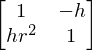

In [9]:
from sympy import *
init_printing()
h, r = symbols('h, r', positive=True)
B = Matrix([[1, -h], [h*r**2, 1]])
B

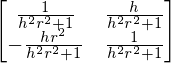

In [2]:
# inverse of B
B**-1

In [3]:
# eigenvalues as a list
L = list((B**-1).eigenvals().keys())

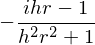

In [4]:
# First eigenvalue
L[0].factor()

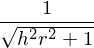

In [5]:
# 2nd eigenvalue
abs(L[1].factor())

$$
\begin{bmatrix}
    \hat\phi_k^{m+1} \\
    \hat\psi_k^{m+1}
\end{bmatrix}
=
\mathbf B^{-1}
\begin{bmatrix}
    \hat\phi_k^{m} \\
    \hat\psi_k^{m}
\end{bmatrix}\exp(ikma).
$$
The eigenvalues of $\mathbf B^{-1}$ are $$\lambda_\pm = \frac{1\pm ihr}{1+h^2r^2}, \qquad |\lambda_\pm| = \frac{1}{\sqrt{1 + h^2r^2}} \leq 1.$$

* The eigenvalues are the growth factors and these are less than one.
* So the implicit method is unconditionally stable.
* But solutions decay exponentially! This is a big problem for the wave equation!

# Crank-Nicholson

Crank-Nicholson: average of explicit (fwd Euler) and implicit methods

Euler:
$$\phi_m^{n+1} = \phi_m^{n} + h\psi_m^{n},$$
$$\psi_m^{n+1} = \psi_m^{n} + h\frac{c^2}{a^2}\left(\phi_{m-1}^{n} + \phi_{m+1}^{n} - 2\phi_m^{n}\right).$$

Implicit:
$$\phi_m^{n+1} - h\psi_m^{n+1} = \phi_m^n,$$
$$\psi_m^{n+1} - h\frac{c^2}{a^2}\left(\phi_{m-1}^{n+1} + \phi_{m+1}^{n+1} - 2\phi_m^{n+1}\right) = \psi_m^{n},$$

Crank-Nicholson (C-N):
$$\phi_m^{n+1} - \frac{h}2\psi_m^{n+1} = \phi_m^{n} + \frac{h}2\psi_m^{n},$$
$$\psi_m^{n+1} - \frac{h}2\frac{c^2}{a^2}\left(\phi_{m-1}^{n+1} + \phi_{m+1}^{n+1} - 2\phi_m^{n+1}\right)= \psi_m^{n} + \frac{h}2\frac{c^2}{a^2}\left(\phi_{m-1}^{n} + \phi_{m+1}^{n} - 2\phi_m^{n}\right).$$

If we do the Von Neumann substitution, $\hat \phi_k^n\exp(ikma)$ and $\hat \psi_k^n\exp(ikma)$, we get
$$\mathbf{B'}
\begin{bmatrix}
    \hat\phi_m^{n+1} \\
    \hat\psi_m^{n+1}
\end{bmatrix}
=
\mathbf{A'}
\begin{bmatrix}
    \hat\phi_m^{n} \\
    \hat\psi_m^{n}
\end{bmatrix},
$$
or 
$$
\begin{bmatrix}
    \hat\phi_m^{n+1} \\
    \hat\psi_m^{n+1}
\end{bmatrix}
=
\mathbf{B'^{-1}A'}
\begin{bmatrix}
    \hat\phi_m^{n} \\
    \hat\psi_m^{n},
\end{bmatrix}
$$
with
$$
\mathbf{B'^{-1}A'}
= \frac{a}{1 + h^2 r'^2}
\begin{bmatrix}
    1 - h^2 r'^2 & 2 h \\
    -2hr'^2 & 1-h^2r'^2
\end{bmatrix},
\quad r' = \frac{c}{a}\sin\frac{ka}{2}
$$

Growth factors of Crank-Nicholson are eigenvalues of $\mathbf{B^{-1}A}$:
$$\lambda_\pm = \frac{1 \pm 2ihr' - h^2 r'^2}{1 + h^2 r'^2},\quad \boxed{|\lambda_\pm| = 1}.$$

* For Euler-Forward, the growth factors are greater than one and the solution diverges.
* For Implicit, the growth factors are less than one and the solution decays to zero.
* For CN, the growth factors are one so the solution neither grows nor decays.
* It is also 2nd-order accurate in time, while both explicit and implicit methods are 1st-order accurate.

# Spectral methods

## General idea

* Find yourself a set of orthogonal functions forming a basis of your function space
    * sin if quantity is zero at boundaries or function is odd w.r.t. midline of domain,
    * cos if quantity has zero derivatives at boundaries or function is even w.r.t. midline of domain,
    * exp if quantity is periodic,
    * Chebyshev polynomials for more flexible combinations of ,
    * Legendre polynomials,
    * ...
* Project your initial conditions and forcing on that basis,
* Iterate in time for linear PDEs,
* Iterate in time, and do FFTs and iFFTs to compute the non-linear terms if PDEs are non-linear,

* We focus on sin/cos/exp bases, sometimes called "Fourier spectral methods" (*perhaps only by me though*),
* Usually, all of these methods usually require computing FFTs (even for non-Fourier spectral methods),
* FFTs: large cost of computing them, but a large return on investment usually:
    * linear PDEs: all modes oscillate independently, without coupling $\Rightarrow$ computing the FFTs of the initial conditions give you the solutions at all times,
    * non-linear PDEs: elliptic PDEs can be solved without the need of an iterative solver like relaxation method
       $$\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = \rho;$$
       $$(\phi, \rho) = \sum_i\sum_j \left(\hat\phi(k,l), \hat\rho(k,l)\right)\exp i(k_ix + l_jy), $$
       $$\text{Use orthogonality to project } \Rightarrow \hat\phi(k_i, l_j) = -\frac{\hat\rho(k_i, l_j)}{k_i^2 + l_j^2}$$
      and you are just one iFFT away form getting the solution $\Rightarrow$ no need to use an iterative solver!
      This is particularly useful with large sets of coupled PDEs, for which just one elliptic PDE can be the main bottleneck of a non-spectral implementation.
* Spectral methods are really difficult to implement in complicated geometries.

# Practical implementation tricks

Periodic B.Cs:
$$f = \sum_{k=-\infty}^{infty} \hat f_k \exp(ikx) \Rightarrow \frac{\partial f}{\partial x} = \sum_{k=-\infty}^{infty} \hat ik f_k \exp(ikx),$$
or, in shorthand,
$$\frac{\partial f}{\partial x} \to ik\hat f_k, \quad \frac{\partial^2 f}{\partial x^2} \to -k^2\hat f_k$$

Next are a couple fo examples of how to implement it.

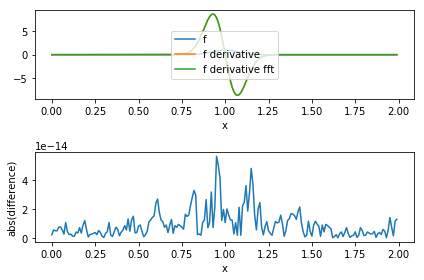

In [7]:
# %load derivative_fft.py
#calculate derivative of a function using fourier transform method
#import required routines
from numpy import arange, exp, pi
from pylab import plot, legend, show,subplot,xlabel,ylabel,tight_layout
from numpy.fft import rfft, irfft
#define function and its derivative
def f(x):
    return exp(-(x-L/2)**2/Delta**2)
def dfdx(x):
    return exp(-(x-L/2)**2/Delta**2)*-2*(x-L/2)/Delta**2

#define problem parameters
L=2.0
Delta=0.1
nx=200

#define x, f(x), f'(x)
x=arange(0,L,L/nx)

f = f(x)

f_derivative = dfdx(x)

#now do the same thing spectrally:
#fourier transform
fhat = rfft(f)
#define k
karray = arange(nx/2+1)*2*pi/L
#define ik*fhat
fhat_derivative = complex(0,1)*karray*fhat
#and transform back
f_derivative_fft = irfft(fhat_derivative)

subplot(2,1,1)
plot(x,f,x,f_derivative,x,f_derivative_fft)
legend(('f','f derivative', 'f derivative fft'))
xlabel('x')
subplot(2,1,2)
plot(x,abs(f_derivative-f_derivative_fft))
xlabel('x')
ylabel('abs(difference)')

tight_layout()
show()

Original series: f = sin(x)-2sin(4x)+3sin(5x)-4sin(6x)
Coefficient of sin(0x): 0.0
Coefficient of sin(1x): 1.0
Coefficient of sin(2x): 1.2569626307521337e-16
Coefficient of sin(3x): -6.786313538289374e-16
Coefficient of sin(4x): -1.9999999999999991
Coefficient of sin(5x): 2.999999999999999
Coefficient of sin(6x): -4.0
See Figure for calculating second derivative


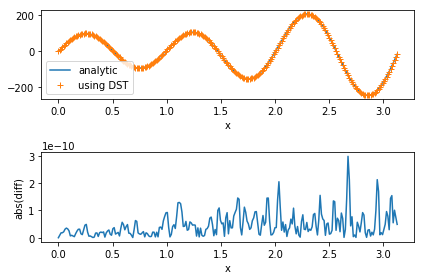

In [10]:
# %load derivative_dst.py
from pylab import plot, show, legend, subplot, xlabel, ylabel, tight_layout
from numpy import zeros, empty, linspace, exp, arange, minimum, pi, sin, cos, array
from dcst import dst, idst, dct, idct

N = 256
# x = pi*n/N
x = arange(N)*pi/N
#function is a sine series
f = sin(x)-2*sin(4*x)+3*sin(5*x)-4*sin(6*x)
#do fourier sine series
fCoeffs = dst(f)
print('Original series: f = sin(x)-2sin(4x)+3sin(5x)-4sin(6x)')
for j in range(7):
    print( 'Coefficient of sin(%ix):'%j, fCoeffs[j]/N)

print('See Figure for calculating second derivative')
#second derivative is also a sine series
d2f_dx2_a = -sin(x)+32*sin(4*x)-75*sin(5*x)+144*sin(6*x)
#second derivative using fourier transform
DerivativeCoeffs = -arange(N)**2*fCoeffs
d2f_dx2_b = idst(DerivativeCoeffs)
subplot(2,1,1) 
plot(x,d2f_dx2_a, x, d2f_dx2_b,'+')
xlabel('x')
legend(('analytic','using DST'))
subplot(2,1,2)
plot(x,abs(d2f_dx2_a-d2f_dx2_b))
xlabel('x')
ylabel('abs(diff)')
tight_layout()
show()
